In [40]:
import albumentations
import numpy as np
import pandas as pd
import os
import glob
import random
from pprint import pprint
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F

from PIL import Image
from PIL import ImageFile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchsummary import summary

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
DIR = "/content/drive/MyDrive/navia_assignment/electoral-tagged/"
BATCH_SIZE = 1
IMG_HEIGHT = 42
IMG_WIDTH = 130
EPOCHS = 25
NUM_WORKERS = 8

In [27]:
#Creating a DF
paths = []
labels = []
for image in os.listdir(DIR):
    paths.append(os.path.join(DIR, image))
    labels.append(image.split(".")[0])

df = pd.DataFrame({
    "paths": paths,
    "labels": labels})

df.head(5)

,paths,labels
0,/content/drive/MyDrive/navia_assignment/electo...,51818
1,/content/drive/MyDrive/navia_assignment/electo...,24715
2,/content/drive/MyDrive/navia_assignment/electo...,42559
3,/content/drive/MyDrive/navia_assignment/electo...,88639
4,/content/drive/MyDrive/navia_assignment/electo...,85734


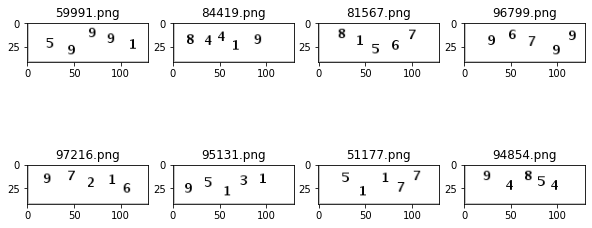

In [28]:
# Displaying the data
f = plt.figure(figsize=(10,10))
i=1
for i in range(8):
  i += 1
  ax = f.add_subplot(4,4,i)
  sample = random.choice(df['paths'])
  image = mpimg.imread(sample)
  ax.set_title(sample.split("/")[-1])
  plt.imshow(image)

In [29]:
def get_loss_function(x, bs, targets):
    log_softmax_values = F.log_softmax(x, 2)

    input_lengths = torch.full(
        size=(bs,), fill_value=log_softmax_values.size(0), dtype=torch.int32
    )

    target_lengths = torch.full(
        size=(bs,), fill_value=targets.size(1), dtype=torch.int32
    )

    return nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)

In [30]:
class MyCaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(MyCaptchaModel, self).__init__()
        
        # CNN Layer
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        # RNN Layer Preprocess
        self.linear1 = nn.Linear(640, 64)
        self.drop1 = nn.Dropout(0.2)
        
        # LSTM GRU
        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars+1)
        
        
    def forward(self, images, targets=None):  
        bs, channel, height, width = images.size()
        
        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)

        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            loss = get_loss_function(x, bs, targets)
            return x, loss
        
        return x, None

In [31]:
model = MyCaptchaModel(1)
print(model)

MyCaptchaModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=640, out_features=64, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (gru): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
)


In [32]:
def train_function(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
        for k, v in data.items():
            data[k] = v.to(DEVICE)
        
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)


def eval_function(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad(): 
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, loss = model(**data)
            fin_loss += loss.item()
            fin_preds.append(batch_preds)

        return fin_preds, fin_loss / len(data_loader)

In [33]:
def encode_targets():
  image_files = glob.glob(os.path.join(DIR, "*.png"))
  targets_orig = [x.split("/")[-1].split(".")[0] for x in image_files]
  targets = [[c for c in x] for x in targets_orig]
  targets_flat = [c for clist in targets for c in clist]

  # Encode images
  lbl_enc = LabelEncoder()
  lbl_enc.fit(targets_flat)

  targets_enc = [lbl_enc.transform(x) for x in targets]
  targets_enc = np.array(targets_enc) + 1
  return image_files, targets_enc, targets_orig, lbl_enc


# Train-test split
image_files, targets_enc, targets_orig, lbl_enc = encode_targets()

(train_imgs, test_imgs, train_targets, test_targets, _, test_orig_targets) = train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.2, random_state=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [34]:
ImageFile.LoadTruncatedImages = True

class DatasetClassifier:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [
             albumentations.Normalize(always_apply=True)
            ]
            )
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        target = self.targets[item]
        
        if self.resize is not None:
            image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
        
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(target, dtype=torch.long)
        }

In [35]:
# Classify images, load using pytorch's DataLoader
train_dataset = DatasetClassifier(
    image_paths=train_imgs, targets=train_targets)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_dataset = DatasetClassifier(
    image_paths=test_imgs, targets=test_targets)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
# Load the models
model = MyCaptchaModel(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

# Create optimizer and callbacks
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)

In [42]:
def early_stopping(patience, count, prev_loss, current_loss, threshold):
    if abs(prev_loss - current_loss) < threshold and count >= patience:
        return "stop" 
    elif abs(prev_loss - current_loss) < threshold:
        return "count"
    else:
        return False


In [43]:
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j,:]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                temp.append(encoder.inverse_transform([k])[0])
        tp = "".join(temp)
        cap_preds.append(tp)
    return cap_preds


In [49]:
patience = 6
count = 0
prev_train_loss = 0
threshold = 0.05
loss = []

for epoch in range(EPOCHS):
    train_loss = train_function(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_function(model, test_loader)
    valid_cap_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_cap_preds.extend(current_preds)
        
    pprint(list(zip(test_orig_targets, valid_cap_preds))[15:20])
    print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
    
    res = early_stopping(patience, count, prev_train_loss, train_loss, threshold)
    
    loss.append(train_loss)
    
    if res == "stop":
        print("Early Stopping Implemented.")
        final_epoch = epoch
        break
    elif res == "count" and train_loss < 0.2:
        count += 1
        print(f"Patience at {patience-count}")
    else:
        prev_train_loss = train_loss

  0%|          | 0/844 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 94/94 [00:01<00:00, 60.67it/s]


[('41352', '--------------------------------'),
 ('79149', '--------------------------------'),
 ('46266', '--------------------------------'),
 ('36757', '--------------------------------'),
 ('53236', '--------------------------------')]
Epoch: 0, train_loss: 2.6405758058290347, valid_loss: 2.5531609312016914


100%|██████████| 94/94 [00:01<00:00, 58.25it/s]


[('41352', '--------------------------------'),
 ('79149', '--------------------------------'),
 ('46266', '--------------------------------'),
 ('36757', '--------------------------------'),
 ('53236', '--------------------------------')]
Epoch: 1, train_loss: 2.534452528750162, valid_loss: 2.5523205615104514


100%|██████████| 94/94 [00:01<00:00, 58.36it/s]


[('41352', '--------------------------------'),
 ('79149', '--------------------------------'),
 ('46266', '--------------------------------'),
 ('36757', '--------------------------------'),
 ('53236', '--------------------------------')]
Epoch: 2, train_loss: 2.529061858122948, valid_loss: 2.543881543139194


100%|██████████| 94/94 [00:01<00:00, 58.91it/s]


[('41352', '--------------------------------'),
 ('79149', '--------------------------------'),
 ('46266', '--------------------------------'),
 ('36757', '--------------------------------'),
 ('53236', '--------------------------------')]
Epoch: 3, train_loss: 2.5263385679484545, valid_loss: 2.5639187478004617


100%|██████████| 94/94 [00:01<00:00, 54.54it/s]


[('41352', '--------------------------------'),
 ('79149', '--------------------------------'),
 ('46266', '--------------------------------'),
 ('36757', '--------------------------------'),
 ('53236', '--------------------------------')]
Epoch: 4, train_loss: 2.5212749587416083, valid_loss: 2.5153062267506376


100%|██████████| 94/94 [00:01<00:00, 56.97it/s]


[('41352', '--------------------------------'),
 ('79149', '--------------------------------'),
 ('46266', '--------------------------------'),
 ('36757', '--------------------------------'),
 ('53236', '--------------------------------')]
Epoch: 5, train_loss: 2.5142824768455108, valid_loss: 2.5218759369342885


100%|██████████| 94/94 [00:01<00:00, 58.18it/s]


[('41352', '8-------------------------------'),
 ('79149', '8-------------------------------'),
 ('46266', '8-------------------------------'),
 ('36757', '8-------------------------------'),
 ('53236', '8-------------------------------')]
Epoch: 6, train_loss: 2.5109609636650267, valid_loss: 2.495373178035655


100%|██████████| 94/94 [00:01<00:00, 57.71it/s]


[('41352', '8-------------------------------'),
 ('79149', '5-------------------------------'),
 ('46266', '8-------------------------------'),
 ('36757', '5-------------------------------'),
 ('53236', '5-------------------------------')]
Epoch: 7, train_loss: 2.4959616587625297, valid_loss: 2.4617439178710288


100%|██████████| 94/94 [00:01<00:00, 58.34it/s]


[('41352', '1-------------------------------'),
 ('79149', '--------------------------------'),
 ('46266', '8-------------------------------'),
 ('36757', '--------------------------------'),
 ('53236', '3-------------------------------')]
Epoch: 8, train_loss: 2.322115534007267, valid_loss: 2.0621492888065096


100%|██████████| 94/94 [00:01<00:00, 57.02it/s]


[('41352', '--4-----1-------3--5---2--------'),
 ('79149', '-------7---9---1-----4-----9----'),
 ('46266', '---4---6--2------6---6----------'),
 ('36757', '----3---6------7--5------7------'),
 ('53236', '-----5---3-----2---3----6-------')]
Epoch: 9, train_loss: 1.44544969273122, valid_loss: 0.4094564619850605


100%|██████████| 94/94 [00:01<00:00, 54.86it/s]


[('41352', '--4-----1-------3--5---2--------'),
 ('79149', '-------7---9---1-----4-----9----'),
 ('46266', '---4---6--2------6---6----------'),
 ('36757', '----3---6------7--5------7------'),
 ('53236', '-----5---3-----2---3----6-------')]
Epoch: 10, train_loss: 0.23868027553227134, valid_loss: 0.04183856207639613


100%|██████████| 94/94 [00:02<00:00, 42.12it/s]


[('41352', '--4-----1-------3--5---2--------'),
 ('79149', '-------7---9---1-----4-----9----'),
 ('46266', '---4---6--2------6---6----------'),
 ('36757', '----3---6------7--5------7------'),
 ('53236', '-----5---3-----2---3----6-------')]
Epoch: 11, train_loss: 0.06218602497492568, valid_loss: 0.015346061923798728


100%|██████████| 94/94 [00:02<00:00, 41.19it/s]


[('41352', '--4-----1-------3--5---2--------'),
 ('79149', '-------7---9---1-----4-----9----'),
 ('46266', '---4---6--2------6---6----------'),
 ('36757', '----3---6------7--5------7------'),
 ('53236', '-----5---3-----2---3----6-------')]
Epoch: 12, train_loss: 0.03646133786676478, valid_loss: 0.008096531677515582
Patience at 5


100%|██████████| 94/94 [00:02<00:00, 36.41it/s]


[('41352', '--4-----1-------3--5---2--------'),
 ('79149', '-------7---9---1-----4-----9----'),
 ('46266', '---4---6--2------6---6----------'),
 ('36757', '----3---6------7--5------7------'),
 ('53236', '-----5---3-----2--33----6-------')]
Epoch: 13, train_loss: 0.027842051903518596, valid_loss: 0.0050922384995848256
Patience at 4


100%|██████████| 94/94 [00:01<00:00, 50.66it/s]


[('41352', '--4-----1-------3--5---2--------'),
 ('79149', '-------7---9---1-----4-----9----'),
 ('46266', '---4---6--2------6---6----------'),
 ('36757', '----3---6------7--5------7------'),
 ('53236', '-----5---3-----2---3----6-------')]
Epoch: 14, train_loss: 0.019683583438731906, valid_loss: 0.003157450659002395
Patience at 3


100%|██████████| 94/94 [00:01<00:00, 52.17it/s]


[('41352', '--4-----1-------3--5---2--------'),
 ('79149', '-------7---9---1-----4-----9----'),
 ('46266', '---4---6--2------6---6----------'),
 ('36757', '----3---6------7--5------7------'),
 ('53236', '-----5---3-----2---3----6-------')]
Epoch: 15, train_loss: 0.021645728846839785, valid_loss: 0.0024752402987747277
Patience at 2


100%|██████████| 94/94 [00:01<00:00, 54.55it/s]


[('41352', '--4-----1-------3--5---2--------'),
 ('79149', '-------7---9---1-----4-----9----'),
 ('46266', '---4---6--2------6---6----------'),
 ('36757', '----3---6------7--5------7------'),
 ('53236', '-----5---3-----2---3----6-------')]
Epoch: 16, train_loss: 0.017801846353965037, valid_loss: 0.0017136290813102683
Patience at 1


100%|██████████| 94/94 [00:01<00:00, 57.81it/s]


[('41352', '--4-----11------3--5---2--------'),
 ('79149', '-------7---9---1-----4-----9----'),
 ('46266', '---4---6--2------6---6----------'),
 ('36757', '----3---6------7--5------7------'),
 ('53236', '-----5---3-----2---3----6-------')]
Epoch: 17, train_loss: 0.016590923554224285, valid_loss: 0.0019242114318098794
Patience at 0


100%|██████████| 94/94 [00:01<00:00, 56.95it/s]

[('41352', '--4-----11------3--5---2--------'),
 ('79149', '-------7---9---1-----4-----9----'),
 ('46266', '---4---6--2------6---6----------'),
 ('36757', '----3---6------7--5------7------'),
 ('53236', '-----5---3-----2---3----6-------')]
Epoch: 18, train_loss: 0.014975065180741612, valid_loss: 0.0012714295614599943
Early Stopping Implemented.


In [50]:
torch.save(model.state_dict(), "./model.bin")

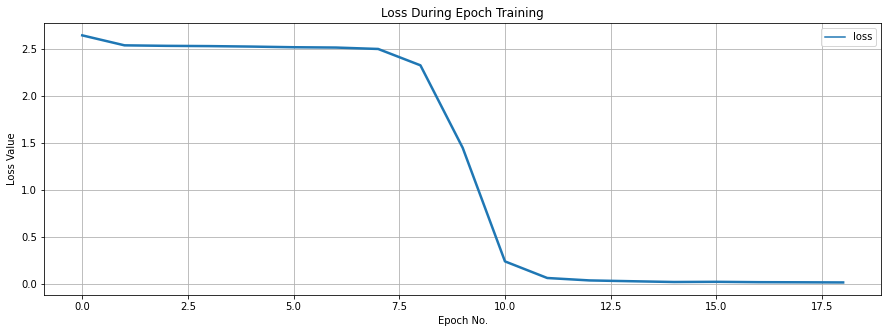

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pytorch = pd.DataFrame({"loss": loss})
plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel("Epoch No.")
plt.ylabel("Loss Value")
plt.title("Loss During Epoch Training")
sns.lineplot(data=df_pytorch, palette="tab10", linewidth=2.5)

In [53]:
model = MyCaptchaModel(9)
model.load_state_dict(torch.load('/content/model.bin'))
model.eval()

MyCaptchaModel(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=640, out_features=64, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (gru): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [61]:
def get_image(image_path=None):
    if image_path == None:
        img = random.choice(df["paths"])
        return [img]
    return [image_path]


def get_sample_photo(image_path=None):
    img = get_image(image_path)
    eval_dataset = DatasetClassifier(
        image_paths=img, targets=[np.array([x for x in np.arange(10)])], resize=(IMG_HEIGHT, IMG_WIDTH)
    )

    eval_loader = torch.utils.data.DataLoader(
        eval_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=False
    )
    
    return img, eval_loader


def predict_function(model, data_loader):
    model.eval()
    fin_preds = []
    with torch.no_grad(): 
        for data in data_loader:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, _ = model(**data)
            fin_preds.append(batch_preds)

        return fin_preds

In [62]:
image_path, eval_loader = get_sample_photo()
print(image_path)

def clean_decoded_predictions(unclean_predictions):
    cleaned_predictions = []
    for i in unclean_predictions:
        if i != "-":
            cleaned_predictions.append(i)
            
    cleaned_predictions = "".join(cleaned_predictions)
    
    if len(cleaned_predictions) == 10:
        return cleaned_predictions   
    
    else:
        prev = "-"
        new_cleaned_predictions = []
        for char in cleaned_predictions:
            if char == prev:
                continue
            new_cleaned_predictions.append(char)
            prev = char
        res = "".join(new_cleaned_predictions)
        return res
    
def predict_captcha(model, eval_loader, image_path):
    plt.figure(figsize=(15,5))
    image = mpimg.imread(image_path[0])
    target = image_path[0].split("/")[-1].split(".")[0]
    plt.title(image_path[0].split("/")[-1])
    plt.imshow(image)
    
    valid_preds = predict_function(model, eval_loader)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
    
    preds = clean_decoded_predictions(current_preds[0])
    
    success = True if preds == target else False

    return{
        "success": success,
        "prediction": preds,
        "real": target
    }

['/content/drive/MyDrive/navia_assignment/electoral-tagged/27481.png']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'prediction': '27481', 'real': '27481', 'success': True}

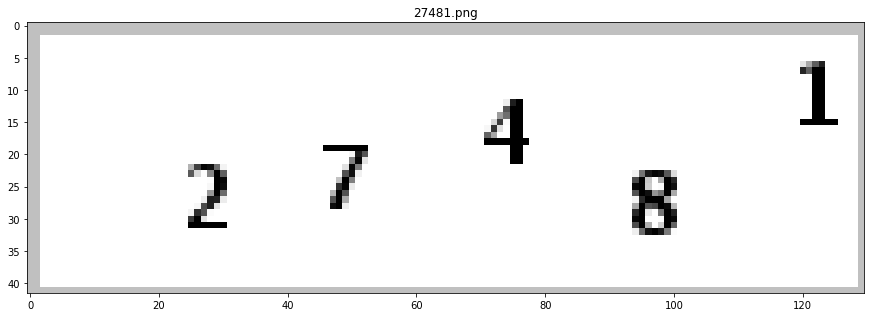

In [63]:
preds = predict_captcha(model, eval_loader, image_path)
preds